# Example 1
Solving $\mathbf{A}\vec{x}=\vec{b}$ where 
$$
\mathbf{A}=
\begin{bmatrix}
3 & 2 & 0\\
1 &-1 & 0\\
0 & 5 & 1
\end{bmatrix}, \quad
\vec{b} =
\begin{bmatrix}
2\\4\\-1
\end{bmatrix}
$$

In [114]:
import numpy as np
from scipy.sparse import csc_matrix
import scipy.sparse.linalg as spla
import time

A = csc_matrix([[3, 2, 0], [1, -1, 0], [0, 5, 1]], dtype=float)
b = np.array([2, 4, -1], dtype=float)

In [116]:
start_time = time.time()
'''
Use Generalized Minimal RESidual iteration to solve Ax=b
exitCode provides convergence information
  0 : sucessful exit
 >0 : convergence to tolerance not achieved, number of iterations
 <0 : illegal input or breakdown
'''
x, exitCode = spla.gmres(A,b) # GMRES iteration without preconditioning
print("--- %s seconds ---" % (time.time() - start_time))
print(exitCode) 
np.allclose(A.dot(x),b) # check if two arrays are element-wise equal within a tolerance

--- 0.0009963512420654297 seconds ---
0


True

In [118]:
# timing GMRES solver with preconditioning
start_time = time.time()
# defining the preconditioner
M2 = spla.spilu(A)
M_x = lambda x: M2.solve(x)
M = spla.LinearOperator((3,3), M_x)

x, exitCode = spla.gmres(A, b, M=M)
print("--- %s seconds ---" % (time.time() - start_time))
print(exitCode) 
np.allclose(A.dot(x),b) # check


--- 0.0009963512420654297 seconds ---
0


True

In [119]:
# exact solution
start_time = time.time()
Ainv = spla.inv(A)
x = Ainv.dot(b)
print("--- %s seconds ---" % (time.time() - start_time))
np.allclose(A.dot(x),b) # check
# A.dot(Ainv.dot(b))-b # check

--- 0.002992391586303711 seconds ---


True

# Example 2
We need to try a larger system to notice any speed-up with the preconditioning. Again, we'll try solving the system $\mathbf{A}\vec{x}=\vec{b}$ but this time $\mathbf{A}$ is a random half-sparse $400\times400$ matrix and $\vec{b}$ is a random vector of length 400

In [121]:
from scipy.sparse import rand
A = rand(400, 400, density=0.5, format="csc", random_state=42)
b = np.random.rand(400,1)

In [122]:
start_time = time.time()
x1, exitCode = spla.gmres(A,b) # GMRES iteration without preconditioning
print("--- %s seconds ---" % (time.time() - start_time))
print(exitCode)
np.allclose(A.dot(x1),b) # check

--- 10.074074983596802 seconds ---
4000


False

In [126]:
# exact solution
start_time = time.time()
Ainv = spla.inv(A)
x = Ainv.dot(b)
print("--- %s seconds ---" % (time.time() - start_time))
np.allclose(A.dot(x),b) # check
# A.dot(Ainv.dot(b))-b # check

--- 0.1855008602142334 seconds ---


True

In [127]:
start_time = time.time()
'''
A preconditioner, P, is chosen such that P is close to A but easy to solve for.
The preconditioner parameter required by this routine is M=P^-1
Here P is computed as an incomplete LU decomposition for a sparse, square matrix. 
'''
n = 400
# Construct a linear operator that computes P^-1 * v.
Pinv = spla.spilu(A) # approximation to the inverse of A
M = spla.LinearOperator((n,n), Pinv.solve)

x2, exitCode = spla.gmres(A,b,M=M)# GMRES solver with preconditioning
print("--- %s seconds ---" % (time.time() - start_time))
print(exitCode) 
np.allclose(np.ravel(b), np.ravel(A.dot(x2)))# check


--- 0.01598978042602539 seconds ---
0


True

In [128]:
# estimating max error for preconditioned GMRES
err = np.subtract(np.ravel(x),np.ravel(x2))
print(err.max())
np.allclose(np.ravel(x),np.ravel(x2))

3.277378368693462e-13


True

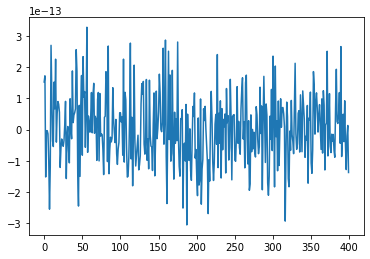

In [129]:
import matplotlib.pyplot as plt
plt.plot(err)
plt.show()

## Next steps:
Try scipy.optimize.newton_krylov with gmres method